<h1 align='center'> PokéBattle Bot Analysis Notebook </h1>

# Introduction

The aim of this project is to delve into the development and analysis of a bot designed to play Pokémon Showdown autonomously. Pokémon Showdown is a popular online battle simulator that provides a competitive platform for players to test their strategic skills in Pokémon battles. By leveraging artificial intelligence techniques, the bot simulates human decision-making, navigating complex battle scenarios to choose the most effective strategies.

### Objectives

This project focuses on three primary objectives. 
- First, it seeks to study the bot's main functions, uncovering how its underlying algorithms allow it to perform tasks such as predicting opponent moves, selecting optimal actions, and adapting to dynamic game conditions. 
- Second, the decision-making logic employed by the bot will be analyzed to understand the mechanisms and heuristics that drive its strategic choices. 
- Third, the project will explore how the bot evaluates potential moves and switches, emphasizing its methods for assessing battle conditions and weighing the outcomes of different actions.

### Tool
Our bot utilizes [Pokémon Showdown](https://pokemonshowdown.com/) to engage in matches with randomly generated teams, facilitated through an [API](https://github.com/pmariglia/showdown).  

Pokémon Showdown is an online simulator designed for competitive Pokémon battles. It faithfully replicates the in-game battling experience and adheres to official rules and community guidelines, making it a favorite among competitive players. Accessible directly through a web browser without any downloads, Pokémon Showdown offers a quick and convenient way to battle.  

Players can either build custom teams by selecting their favorite Pokémon, moves, abilities, and strategies, or opt for random battles with automatically generated teams. Our bot focuses on the latter, engaging in exciting random battles to showcase its capabilities.  

Pokémon Showdown is a professional web platform widely used in Pokémon eSports. Renowned for its fidelity to the official competitive environment, Pokémon Showdown sets a high standard by following standardized rules and community guidelines.  

### Implementation
Given the complexity of its advanced features and its status as a benchmark in online Pokémon battles, fully replicating the platform within a notebook is highly challenging. Instead, the notebook provides a simulation that also utilizes a genetic algorithm to optimize certain strategies. To see the actual bot in action and explore the project in detail, please refer to our [GitHub](https://github.com/MatteoPirii/PokeBattle) repository and its README file, where a comprehensive description is available.  



---
# Releted Works

To make the following code execution possible, we first need to download and import the necessary files from the API.
- constants.py: A Python file with predefined constants.
- moves.json: A JSON file containing move data for Pokémon (e.g., names, types, power, etc.).
- pokedex.json: A JSON file containing Pokémon data (e.g., stats, abilities, and other details).
- utility.py: A Python source file containing utility methods defined for our agent.
- state_eval.py: A Python source file containing functions to evaluate the battle state.
- helpers.py: A Python source file containing functions needed for the environment.

In [26]:
user = "MatteoPirii"
repo = "PokeBattle"

def download(pyfile: str):
    url = f"https://raw.githubusercontent.com/{user}/{repo}/master/{pyfile}"
    !wget --no-cache -P data/jupyter/ -N {url}

download("constants.py")
download("data/moves.json")
download("data/pokedex.json")
download("showdown/battle_bots/PokeBattle/utility.py")
download("showdown/battle_bots/PokeBattle/state_eval.py")
download("showdown/battle_bots/helpers.py")

"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [27]:
from copy import deepcopy
import importlib
import json
import logging
import math
import os
import random
import time

PWD = os.getcwd() + "/data/jupyter/"
constants = importlib.import_module('data.jupyter.constants')
utility = importlib.import_module('data.jupyter.utility')
state_eval = importlib.import_module('data.jupyter.state_eval')
helpers = importlib.import_module('data.jupyter.helpers')

game_over = utility.game_over
format_decision = helpers.format_decision


ModuleNotFoundError: No module named 'data.jupyter'

In [ ]:

# Maximum depth of exploration for minimax
MAX_DEPTH = 18

# 10 seconds of tolerance
TIME_TOLLERANCE = 10

# Define the path to the 'moves.json' file using the present working directory (PWD)
move_json_location = os.path.join(PWD, 'moves.json')
# Open the 'moves.json' file and load its content as a Python dictionary
with open(move_json_location) as f:
    all_move_json = json.load(f) # Load the JSON file

# Define the path to the 'pokedex.json' file using the present working directory (PWD)
pkmn_json_location = os.path.join(PWD, 'pokedex.json')
# Open the 'pokedex.json' file and load its content as a Python dictionary
with open(pkmn_json_location, 'r') as f:
    pokedex = json.loads(f.read()) # Load the JSON file

The next step is to define the classes used in the project

In [ ]:
def normalize_name(name):
    return name\
        .replace(" ", "")\
        .replace("-", "")\
        .replace(".", "")\
        .replace("\'", "")\
        .replace("%", "")\
        .replace("*", "")\
        .replace(":", "")\
        .strip()\
        .lower()\
        .encode('ascii', 'ignore')\
        .decode('utf-8')

def common_pkmn_stat_calc(stat: int, iv: int, ev: int, level: int):
    return math.floor(((2 * stat + iv + math.floor(ev / 4)) * level) / 100)

def calculate_stats(base_stats, level, ivs=(31,) * 6, evs=(85,) * 6, nature='serious'):
    new_stats = dict()

    new_stats[constants.HITPOINTS] = common_pkmn_stat_calc(
        base_stats[constants.HITPOINTS],
        ivs[0],
        evs[0],
        level
    ) + level + 10

    new_stats[constants.ATTACK] = common_pkmn_stat_calc(
        base_stats[constants.ATTACK],
        ivs[1],
        evs[1],
        level
    ) + 5

    new_stats[constants.DEFENSE] = common_pkmn_stat_calc(
        base_stats[constants.DEFENSE],
        ivs[2],
        evs[2],
        level
    ) + 5

    new_stats[constants.SPECIAL_ATTACK] = common_pkmn_stat_calc(
        base_stats[constants.SPECIAL_ATTACK],
        ivs[3],
        evs[3],
        level
    ) + 5

    new_stats[constants.SPECIAL_DEFENSE] = common_pkmn_stat_calc(
        base_stats[constants.SPECIAL_DEFENSE],
        ivs[4],
        evs[4],
        level
    ) + 5

    new_stats[constants.SPEED] = common_pkmn_stat_calc(
        base_stats[constants.SPEED],
        ivs[5],
        evs[5],
        level
    ) + 5

    new_stats = {k: int(v) for k, v in new_stats.items()}
    return new_stats
from typing import List


In [ ]:

# Define simple move class to simulate move options
class Move:
    def __init__(self, name):
        name = normalize_name(name)
        if constants.HIDDEN_POWER in name and not name.endswith(constants.HIDDEN_POWER_ACTIVE_MOVE_BASE_DAMAGE_STRING):
            name = "{}{}".format(name, constants.HIDDEN_POWER_ACTIVE_MOVE_BASE_DAMAGE_STRING)
        move_json = all_move_json[name]
        self.name = name
        self.max_pp = int(move_json.get(constants.PP) * 1.6)

        self.disabled = False
        self.can_z = False
        self.current_pp = self.max_pp
        self.accuracy: int | bool
        try:
            self.accuracy = int(move_json.get(constants.ACCURACY))
        except:
            self.accuracy = bool(move_json.get(constants.ACCURACY))

        self.basePower: int = int(move_json.get(constants.BASE_POWER))
        self.type: str = move_json.get(constants.TYPE)
        self.status: str = move_json.get(constants.STATUS)
        self.category: str = move_json.get(constants.CATEGORY)

In [ ]:
class Pokemon:

    def __init__(self, name: str, moves, level = 70, nature="serious", evs=(85,) * 6):
        self.name = normalize_name(name)
        self.nickname = None
        self.base_name = self.name
        self.level = level
        self.nature = nature
        self.evs = evs
        #self.speed_range = StatRange(min=0, max=float("inf"))

        try:
            self.base_stats = pokedex[self.name][constants.BASESTATS]
        except KeyError:
            self.name = [k for k in pokedex if self.name.startswith(k)][0]
            self.base_stats = pokedex[self.name][constants.BASESTATS]

        self.stats = calculate_stats(self.base_stats, self.level, nature=nature, evs=evs)

        self.max_hp = self.stats.pop(constants.HITPOINTS)
        self.hp = self.max_hp
        if self.name == 'shedinja':
            self.max_hp = 1
            self.hp = 1

        self.ability = None
        self.types = pokedex[self.name][constants.TYPES]
        self.item = constants.UNKNOWN_ITEM

        self.terastallized = False
        self.fainted = False
        self.reviving = False
        self.moves = moves
        self.status: str | None = None
        self.volatile_statuses = []
        self.boosts = None
        self.can_mega_evo = False
        self.can_ultra_burst = False
        self.can_dynamax = False
        self.is_mega = False
        self.can_terastallize = False
        self.can_have_assaultvest = True
        self.can_have_choice_item = True
        self.can_not_have_band = False
        self.can_not_have_specs = False
        self.can_have_life_orb = True
        self.can_have_heavydutyboots = True

    def is_alive(self):
        return self.hp > 0

In [ ]:
class Battler:
    def __init__(self, user_dict: dict):
        self.active: Pokemon = user_dict["active"]
        self.reserve: list[Pokemon] = user_dict["reserve"]

In [ ]:
class BattleBot:
    def __init__(self, user, opponent):
        self.user = user
        self.opponent = opponent
        self.start_time = None
        self.debug = True  # Example, this can be changed based on need
        self.time_remaining = 100  # Example starting time
        self.force_switch = False  # Example, this can be changed based on need

    def get_pkmn_by_switch(self, switch: str) -> Pokemon:
        """Returns Pokémon from a switching string"""
        name = switch.split(' ')[1]
        pkmn = self.get_pokemon_by_name(name)
        return pkmn

    def restore_state(self, saved_state):
        """Restores battle state after single move simulation"""
        self.__dict__.update(saved_state.__dict__)
    
    def get_pokemon_by_name(self, name: str) -> Pokemon | None:
        """Returns the Pokémon with the name took from user reserve."""

        # Remove switch prefix if present
        if name.startswith(f"{constants.SWITCH_STRING} "):
            name = name.split(" ", 1)[1]

        normalized_name: str = normalize_name(name)
        for pokemon in self.user.reserve:
            if pokemon.name.lower() == normalized_name:
                return pokemon
        return None

---
# Metodologies

From this point onward, the notebook contains the code for our bot, providing a detailed view of the methodologies employed and the functions implemented. Here, you can explore the logical structure of the project, understand the algorithms utilized, and examine the step-by-step implementation of each feature.  

The code is designed to demonstrate the core principles behind our approach, offering insights into the strategies and techniques that drive the functionality of the bot. By delving into the provided implementation, you can gain a comprehensive understanding of how the project operates and the reasoning behind key design choices.  

The main function that we will see are in the class BattleBot (different from the last one) that is the main core of our agent.

## Best action selection

The `find_best_move` function is a core component of the Pokémon Showdown bot. It determines the optimal action (move or switch) during each turn by employing the Minimax algorithm and considering factors such as the Pokémon's health, available moves, and the overall game state.

### **Function Breakdown**

### Purpose
- To identify and execute the best possible action for the current game turn.
- To account for both short-term and long-term consequences of each action using simulation and evaluation.

### Key Steps

1. **Initial Validation**
   - Checks if the active Pokémon is alive:
     - If **not alive**, attempts to find the best switch option.
     - If no switches are available, returns an error or a placeholder action.
&nbsp;          
2. **Option Categorization**
    - Retrieves and categorizes all available actions into **moves** and **switches** using the `options_categorization` function.
    - Handles scenarios where switching is forced or no moves are available.
&nbsp;
3. **Move Evaluation with Minimax**
   - Combines all valid moves and switches into a single list.
   - Simulates each move using `apply_move` and evaluates its impact on the game state via the Minimax algorithm.
   - Restores the original game state after each simulation to avoid side effects.
&nbsp;
4. **Final Decision**
   - Selects the move or switch with the highest evaluated score.
   - Formats the decision and adjusts the remaining time.
   - Includes a fallback mechanism to randomly select an action if no optimal move is identified.

In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)

    def find_best_move(self, user_options, switches) -> list[str]:
        """Finds best move or best switch using Minimax"""
        best_move = None
        max_value = float('-inf')
        self.start_time = time.time()  # timer start

        # Check if the Pokémon is alive or inactive
        if not self.user.active.is_alive():
            print("Error: active Pokémon is invalid or exhausted.") if self.debug else None
            switches = [f"{constants.SWITCH_STRING} {name}" for name in self.user.get_switches()]
            if switches:
                selected_switch = self.find_best_switch()
                if selected_switch:
                    self.apply_move(f"{constants.SWITCH_STRING} {selected_switch.name}")
                    self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
                    return format_decision(self, f"{constants.SWITCH_STRING} {selected_switch.name}")
            else:
                return ["no valid move or switch"]

        # Get all available moves and switches
        print(f"Available moves: {user_options}") if self.debug else None
        moves = user_options

        # If we're forced to switch or there are no available moves the first switch is returned
        if self.force_switch or not moves:
            if not switches:
                print("Error: no available switch.") if self.debug else None
                self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
                return ["no valid move or switch"]

            switch = self.find_best_switch()
            if switch is None:
                switch = self.get_pkmn_by_switch(switches[0])

            selected_switch = format_decision(self, f"{constants.SWITCH_STRING} {switch.name}")
            print(f"Selected switch: {selected_switch}") if self.debug else None
            self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
            return selected_switch

        combined_options = moves.copy()
        combined_options.sort(key=lambda move: self.evaluate_move(move), reverse=True)
        switch = self.find_best_switch()
        if switch:
            combined_options.append(f"{constants.SWITCH_STRING} {switch.name}")

        # Execute MiniMax for each option
        for move in combined_options:
            saved_state = deepcopy(self)  # Saving the battle state
            self.apply_move(move)  # Choice simulation
            move_value = self.minimax(alpha=float('-inf'), beta=float('inf'))

            self.restore_state(saved_state)  # Battle state recovery

            if move_value > max_value:
                print(f"AAAAAA: {move_value}")
                max_value = move_value
                best_move = move

        # Select highest damage move
        if (best_move is not None or max_value > 0) and not game_over(self.user, self.opponent):
            selected_move = format_decision(self, best_move)
            print(f"Best found move: {selected_move}")
            self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
            return selected_move  # returns formatted decision

        # If no move is deemed "best," pick a random one
        if best_move is None and not game_over(self.user, self.opponent):  # If no best move was found by Minimax
            print(f"No best move found. Falling back to a random choice. {user_options}")
            best_move = random.choice(user_options)  # Random fallback choice
            selected_move = format_decision(self, best_move)
            self.time_remaining = utility.adjust_time(int(time.time() - self.start_time), self.time_remaining)
            return selected_move

---
## Advantages
- **Strategic Depth**: Evaluates both immediate and future outcomes of each action using Minimax.
- **Resilience**: Includes fallback mechanisms to handle edge cases (e.g., no valid moves).
- **Game State Simulation**: Ensures accurate decision-making by simulating and reverting actions.

## Limitations
- **Time Complexity**: Running Minimax for all actions can be computationally expensive, especially at higher depths.


---

## Simulation of the action

The `apply_move` function simulates the effect of a move or a switch during a battle, considering factors like type advantage, accuracy, and damage calculation.

### **Function Breakdown**

### Purpose
- To execute a move or switch action within a simulated game state.
- To evaluate the effects of the action, including status changes and damage dealt.

### Key Steps

1. **Handling Switches**
   - If the move is a switch, the function updates the `active` Pokémon without further calculations.
&nbsp;
2. **Move Accuracy**
   - Simulates whether the move hits, based on its accuracy.
   - If the move misses, the function logs the event and exits.
&nbsp;
3. **Damage Calculation**
   - Computes damage inflicted by the move using several factors:
     - Base power of the move.
     - Type effectiveness between the move and the opponent's Pokémon.
     - Levels of the attacker and defender.
&nbsp;
4. **Logging Results**
   - Outputs details about the damage inflicted and the type multiplier for debugging purposes.
&nbsp;
5. **Applying Status Effects**
   - If the move has a status effect (e.g., paralysis or burn), it is applied to the opponent.
   - Logs the status change for debugging.



In [ ]:
from showdown.battle_bots.PokeBattle.main import calculate_type_multiplier
from showdown.battle_bots.PokeBattle.main import calculate_damage

class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)
    
    def apply_move(self, move_name: str) -> None:
        """Apply simulated move or switch considering type advantage"""
        move_part = move_name.split()

        if constants.SWITCH_STRING in move_name and len(move_part) > 1:
            self.user.active = Pokemon.from_switch_string(move_part[1])
            return

        # Damage, status effect and stats changes simulation
        move = Move(move_name)

        # Accuracy based move success rate calculation
        if random.randint(1, 100) > move.accuracy:
            if self.debug:
                print(f"{self.user.active.name} missed the move {move.name}.")
            return

        # Damage calculation considering types
        type_multiplier = calculate_type_multiplier(move.type, self.opponent.active.types)

        damage = calculate_damage(self.user.active, self.opponent.active, move)
        damage *= type_multiplier
        damage *= (self.user.active.level / self.opponent.active.level)

        self.opponent.active.hp -= math.floor(damage)
        print(f"{move.name} inflicted {damage:.2f} hp of damage to {self.opponent.active.name} with an "
              f"efficacy multiplier of {type_multiplier}.") if self.debug else None

        # The move has no secondary effects
        if move.status is not None:
            self.opponent.active.status = move.status
            print(f"{self.opponent.active.name} has been {move.status}!") if self.debug else None
        else:
            print(f"{self.user.active.name} missed the move {move.name}.") if self.debug else None

---

## Advantages
- **Comprehensive Simulation**: Covers accuracy, type advantages, and damage scaling based on levels.
- **Debugging Support**: Provides detailed logs for tracking actions and their effects.

## Limitations
- **No Secondary Effects**: The current implementation does not handle secondary effects like stat changes or healing.
- **Simplistic Status Application**: Assumes status effects apply directly without additional checks.

---

## Evaluation of the state
The `evaluate_state` function assesses the current battle state and assigns a numerical score to indicate the user's advantage or disadvantage. A higher score reflects a more favorable position for the user, while a lower score suggests a disadvantage. 

### **Function breakdown**

### Purpose
To evaluate the current battle state based on various factors such as health, level, type advantage, reserves, weather, and status conditions, helping to make informed decisions during battle.

### Key Steps
1. **Active Pokémon Status**:
    - Assigns a large penalty if the user's active Pokémon has fainted.
    - Assigns a high reward if the opponent's active Pokémon has fainted.
&nbsp;  
2. **Health and Level Difference**:
    - Scores the difference in percentage HP between the user's and opponent's active Pokémon.
    - Adds or subtracts points based on the level difference.
&nbsp;  
3. **Reserve Pokémon**:
    - Rewards having healthy Pokémon in the user's reserves.
    - Penalizes the opponent's healthy reserves.
&nbsp;  
4. **Type Advantage**:
    - Rewards having a type advantage and penalizes type disadvantage based on a multiplier.
&nbsp;
5. **Weather Conditions**:
    - Adjusts the score based on how weather impacts the user's and opponent's Pokémon.
&nbsp;
6. **Status Conditions**:
    - Penalizes status conditions on the user's active Pokémon (e.g., paralysis, burn).
    - Rewards status conditions on the opponent's active Pokémon.
&nbsp;
7. **Stat Boosts**:
    - Evaluates boosts or reductions in stats, rewarding moderate boosts and penalizing extreme ones or reductions.
&nbsp;
8. **Healing Move Usage**:
    - Penalizes using healing moves unnecessarily (e.g., if the user's HP is already high).
&nbsp;
9. **Worst-Case Opponent Moves**:
    - Considers the most damaging move the opponent could use and adjusts the score accordingly.
&nbsp;
10. **Random Tie-Breaker**:
    - Adds a small random factor to break ties in evaluations.
&nbsp;
11. Returns a numerical score representing the overall battle state. A positive score indicates an advantage, while a negative score indicates a disadvantage.

In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)
        
    def evaluate_state(self) -> float:
        """Battle state evaluation"""
        score = 0

        # Check if active Pokémon are alive
        if not self.user.active.is_alive():
            return float('-inf')  # Heavy penalty if user's active Pokémon is fainted
        if not self.opponent.active.is_alive():
            return float('inf')  # High reward if opponent's active Pokémon is fainted

        # 1. Scores by HP difference and level
        hp_percent_user = self.user.active.hp / self.user.active.max_hp
        hp_percent_opponent = self.opponent.active.hp / self.opponent.active.max_hp
        level_diff = self.user.active.level - self.opponent.active.level
        score += (hp_percent_user - hp_percent_opponent) * 50
        score += level_diff * 5

        # 2. Bonus/penalty for alive reserve
        user_reserve_score = sum(10 for p in self.user.reserve if p.hp > 0)
        opponent_reserve_score = sum(10 for p in self.opponent.reserve if p.hp > 0)
        score += user_reserve_score - opponent_reserve_score

        # 3. Bonus/penalty for type advantage/disadvantage
        type_advantage_multiplier = calculate_type_multiplier(self.user.active.types[0], self.opponent.active.types)
        if type_advantage_multiplier > 1:
            score += 120 * type_advantage_multiplier  # Bonus for type advantage
        elif type_advantage_multiplier < 1 and type_advantage_multiplier != 0:
            score -= 100 * (1 / type_advantage_multiplier)  # Penalty for type disadvantage
        else:
            score -= 150

        # 4. Bonus for weather conditions
        score += state_eval.weather_condition(self.user.active, self.opponent.active, self.weather)

        # 5. Penalty for status conditions
        status_penalty = {
            constants.PARALYZED: 30,
            constants.POISON: 35,
            'badly poisoned': 40,
            constants.BURN: 25,
            constants.SLEEP: 60,
            constants.FROZEN: 70,
        }
        score -= status_penalty.get(self.user.active.status, 0)
        score += status_penalty.get(self.opponent.active.status, 0)

        # 6. Evaluate user's boost status
        for boost, value in self.user.active.boosts.items():
            if value < 0:
                score -= 20
            elif 0 < value <= 4:
                score += 30
            elif value > 4:
                score -= 10

        # 7. Evaluate user's boost status
        status_move = [move for move in self.user.active.moves if
                       "heal" in all_moves.get(move.name.lower(), {}).get("flags", {})]
        if status_move and hp_percent_user >= 0.85:
            score -= 120

        # 8. Integrate worst-case opponent move analysis
        opponent_moves = self.opponent.active.moves
        if opponent_moves:
            worst_opponent_score = min(
                self.evaluate_move_risk(move, self.user.active) for move in opponent_moves
            )
            score += worst_opponent_score  # Adjust score with worst-case scenario

        # 9. Random factor for tie-breaking decisions
        score += random.uniform(-1, 1)

        return score

---

## Advantages
- **Comprehensive Evaluation**: The function considers a wide range of factors, including HP, levels, type advantages, weather, and status effects, providing a nuanced assessment of the battle state.
- **Opponent Move Risk Analysis**: It accounts for worst-case opponent moves, ensuring defensive awareness and improving the reliability of its state evaluation.
## Limitations
- **High Computational Complexity**: Evaluating multiple factors, especially worst-case opponent moves, can be computationally intensive, leading to slower decision-making.
- **Static Weighting Issues**: Some factors, like type effectiveness or status penalties, are given fixed weights that may not reflect their situational importance, potentially skewing the evaluation.

---

## Best Pokémon Selection
The `find_best_switch` function identifies the best Pokémon from the user's team to switch into battle based on their resistance to the opponent's active Pokémon's types and the strength of their moves.

### **Function breakdown**

### Purpose
To find the optimal Pokémon to switch into the battle based on a combination of type resistance and move effectiveness.

### Key Steps
1. Iterates through all the user's available Pokémon switches.
2. For each Pokémon, calculates a resistance score based on its types and the opponent's Pokémon's types using a type-effectiveness table.
3. Keeps track of Pokémon with the highest resistance score. If multiple Pokémon have the same score, they are considered as candidates for the best switch.
4. Among the candidates, evaluates their potential move scores with the `pokemon_score_moves` function and selects the one with the highest move score.
5. Returns the best Pokémon to switch in. If no suitable Pokémon is found, it returns None. 

### Error Handling
Ensures Pokémon exist in the team before evaluation and handles cases where no suitable candidates are found.


In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)
        
    def find_best_switch(self) -> Pokemon | None:
        # Find the best Pokémon in the team to make the switch.
        best_pokemon = None
        max_score = float('-inf')
        best_move_score = float('-inf')
        best_pokemon_candidates = []

        opponent_types = self.opponent.active.types

        for switch in self.user.get_switches():
            pokemon_to_switch = switch

            if pokemon_to_switch is None:
                if self.debug:
                    print(f"Error: Pokémon {switch} not found in the user's reserve.")
                    continue

            # Evaluate the resistance of the reserve Pokémon against the opponent's type
            resistance = 0
            resistance += sum(constants.TYPE_EFFECTIVENESS.get(switch_type, {}).get(opponent_type, 1)
                              for opponent_type in opponent_types
                              for switch_type in pokemon_to_switch.types)

            # Combine resistance and move score for overall evaluation
            total_move_score = resistance

            if total_move_score > max_score:
                max_score = total_move_score
                best_pokemon_candidates = [pokemon_to_switch]  # Reset the list of best candidates
            elif total_move_score == max_score:
                best_pokemon_candidates.append(pokemon_to_switch)  # Add to the list of best candidates

        # Choose the best Pokémon from the candidates
        if best_pokemon_candidates:
            # if we have more than one candidate choose a heuristic to select the best Pokémon
            # we choose the Pokémon with the best move
            for pokemon in best_pokemon_candidates:

                # Calculate the move score
                move_score = self.pokemon_score_moves(pokemon_to_switch.name)

                if move_score > best_move_score:
                    best_move_score = move_score
                    best_pokemon = pokemon
            # if self.debug:
            print(f"Best switch: {best_pokemon.name} with a total score of {max_score}") if self.debug else None
        elif self.debug:
            print("No suitable Pokémon found.") if self.debug else None

## Evaluation of Pokémon Moves
The `pokemon_score_moves` function evaluates the effectiveness of a Pokémon's moves and returns a score that reflects the quality of its best move.

### **Function breakdown**

### Purpose
To assess the strength of a Pokémon's moves, accounting for move power and accuracy, and return a score for the best move.

### Key Steps
1. Retrieves the Pokémon object by its name.
2. Iterates through the Pokémon's available moves.
3. For each move:
    - Evaluates its base effectiveness using the `evaluate_move` method.
    - Adjusts the move's score based on its accuracy.
4. Tracks the highest move score during iteration.
5. Returns the total score of the best move for the Pokémon.

### Error Handling
If the Pokémon cannot be found, prints an error message and returns a score of 0.


In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)
        
    def pokemon_score_moves(self, pokemon_name: str) -> float:
        """Find if the moves of the Pokémon are good or not"""
        pokemon = self.get_pokemon_by_name(pokemon_name)  # Get Pokémon object from the name
        max_score = float('-inf')

        if pokemon is None:
            print(f"Error: Pokémon {pokemon_name} not found.")
            return 0

        total_score = 0

        for move in pokemon.moves:
            move_score = self.evaluate_move(move)
            accuracy_multiplier = move.accuracy / 100 if isinstance(move.accuracy,
                                                                    int) else 1  # Assuming accuracy is between 0 and
            # 100 (adjust the move score based on the accuracy of the move)
            total_score = move_score * accuracy_multiplier

            if total_score > max_score:
                max_score = total_score

        print(f"Total score for {pokemon_name}: {total_score}") if self.debug else None

        return total_score

---

## Advantages
- **Strategic Decision-Making**: Incorporates the quality of a Pokémon's moves as a secondary heuristic to ensure that the selected Pokémon is not only defensive but also offensively viable.
- **Move Evaluation**: Considers both move effectiveness (via evaluate_move) and accuracy, offering a realistic assessment of each move's reliability.

## Limitations
- **Limited Context Awareness**: The function doesn't account for battle-specific conditions like weather, stat boosts, or status effects, which can heavily influence optimal switches.
- **Candidate Refinement**: During the candidate refinement phase in find_best_switch, the pokemon_score_moves function is called for each candidate Pokémon. If multiple candidates have identical resistance scores, this could lead to redundant evaluations.

---

## Move Evaluation
The `evaluate_move` function evaluates the effectiveness of a Pokémon move in a battle scenario. It calculates the potential damage a move can inflict on the opponent's Pokémon by considering several factors such as type effectiveness, the Pokémon's level, and the specific move used.

In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)

    def evaluate_move(self, move_name: str) -> float:
        """Evaluate the move based on the type effectiveness against the opponent's Pokémon."""
        if isinstance(move_name, Move):            
            move_name = move_name.name  # Usa il nome se è un oggetto Move


        move = Move(move_name)  # Create an instance of Move using the move name as a string
        if not move:
            print(f"Error: Move {move_name} not found.") if self.debug else None
            return 0

        # Calculate the type multiplier
        type_multiplier = calculate_type_multiplier(move.type, self.opponent.active.types)
        # Calculate the potential damage inflicted
        damage = calculate_damage(self.user.active, self.opponent.active, move) * type_multiplier

        # Consider the opponent's Pokémon level
        damage *= (self.user.active.level / self.opponent.active.level)

        print(f"Move {move.name} inflicts {damage:.2f} damage to {self.opponent.active.name}.") if self.debug else None
        return damage

## Minimax algorithm
The provided code implements a Minimax algorithm with Alpha-Beta pruning for decision-making in a Pokémon battle simulator. This algorithm enables the bot to determine the best possible move by simulating and evaluating all possible outcomes of a game tree up to a specified depth.

### **Function Breakdown**

#### **Minimax**
The `minimax` function is the main entry point for the Minimax algorithm. It evaluates the game state recursively to determine the optimal action for the bot.
#### *Logic*:
If a terminal state is reached (e.g., no further moves or maximum depth reached), it evaluates the current state using `evaluate_state` and returns the score.
Otherwise, it begins the recursive evaluation by calling the maximizing function `max_eval`.

#### **Max eval**
The `max_eval` function represents the "maximizing" player's (bot's) turn. It tries to maximize the bot's evaluation score by selecting the most favorable move.
#### *Logic*:
Checks for terminal states or maximum depth, evaluating the game state if true.
Separates potential moves into "moves" (actions taken by the active Pokémon) and "switches" (changing the active Pokémon).
Sorts moves based on their evaluation score and appends the best switch, if available.
Simulates each move:
Saves the current state (deepcopy).
Applies the move and recursively calls the minimizing function `min_eval` for the opponent's turn.
Restores the state after simulation.
Updates alpha with the highest evaluation score.
Prunes unnecessary branches if the evaluation exceeds beta.

#### **Min eval**
The `min_eval` function represents the "minimizing" player's (opponent's) turn. It tries to minimize the bot's evaluation score by selecting the most detrimental move for the bot.
#### *Logic*:
Similar to `max_eval`, but it focuses on minimizing the evaluation score.
Iterates through the opponent's possible moves, simulating each move and calling `max_eval` recursively for the bot's next turn.
Updates beta with the lowest evaluation score.
Prunes unnecessary branches if the evaluation is less than or equal to alpha.

### **Key Features:**
- *Alpha-Beta Pruning*: Optimizes the Minimax algorithm by avoiding the evaluation of branches that are guaranteed to be suboptimal. This reduces the computational cost.
- *Recursive State Evaluation*: Alternates between maximizing and minimizing turns, simulating potential moves for both the bot and its opponent.
- *Move Sorting*: The bot prioritizes moves based on their evaluation scores, improving the efficiency of the algorithm.
- *State Management*: Uses deepcopy to save and restore the battle state during simulations, ensuring that no permanent changes affect subsequent evaluations.


In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)

    def minimax(self, alpha: float, beta: float, max_depth: int = MAX_DEPTH) -> float:
        """Minimax algorithm with Alpha-Beta cutting-out."""

        if self.is_terminal(max_depth):
            score = self.evaluate_state()
            print(f"Terminal state reached. Evaluation score: {score}") if self.debug else None
            return score

        return self.max_eval(alpha, beta, max_depth)

    def max_eval(self, alpha: float, beta: float, max_depth: int) -> float:
        max_eval = float('-inf')
        user_options = self.user.active.moves

        if self.is_terminal(max_depth):
            score = self.evaluate_state()
            print(f"Terminal state reached. Evaluation score: {score}") if self.debug else None
            return score

        # Separate moves from switches
        moves = [move for move in user_options if not move.name.startswith(constants.SWITCH_STRING)]

        # Sort moves by importance
        moves.sort(key=lambda move: self.evaluate_move(move), reverse=True)
        switch = self.find_best_switch()
        if switch:
            moves.append(f"{constants.SWITCH_STRING} {switch.name}")

        # Evaluate moves
        for move in moves:
            saved_state = deepcopy(self)  # Save the battle state before simulating the move

            self.apply_move(move.name)
            eval = self.min_eval(alpha, beta, max_depth - 1)
            self.restore_state(saved_state)  # Restore the battle state

            if eval > max_eval:
                max_eval = eval
                alpha = max(alpha, eval)

            if max_eval >= beta:
                return max_eval  # Alpha-Beta pruning

        return max_eval

    def min_eval(self, alpha: float, beta: float, max_depth: int) -> float | int:
        min_eval = float('inf')
        opponent_options = self.opponent.active.moves

        if self.is_terminal(max_depth):
            score = self.evaluate_state()
            print(f"Terminal state reached. Evaluation score: {score}") if self.debug else None
            return score

        for move in opponent_options:
            saved_state = deepcopy(self)  # Save battle state before moving

            self.apply_move(move.name)
            eval = self.max_eval(alpha, beta, max_depth - 1)  # Bot turn, maximizing
            self.restore_state(saved_state)

            if eval < min_eval:
                min_eval = eval
                beta = min(beta, eval)

            if min_eval <= alpha:
                return min_eval

        return min_eval

---

## Advantages
- **Optimized Decision-Making:** Alpha-Beta pruning ensures efficient evaluation by reducing the number of game states explored.
- **Strategic Depth:** By simulating multiple turns, the bot anticipates both its own and the opponent’s actions.
- **Dynamic Adaptation:** Incorporates move evaluation and switching strategies for more realistic gameplay.

## Limitations
- **Computational Cost:** Despite pruning, the algorithm can still be slow for large game trees or high max_depth.
- **Heuristic Dependency:** The effectiveness depends on the accuracy of the `evaluate_state` and `evaluate_move` heuristics. Inaccurate evaluations can lead to suboptimal decisions.

---

## Timer management

One of the primary challenges we faced was managing Pokémon Showdown's 150-second timer. At times, the bot would lose battles because computationally expensive decision-making processes caused it to exceed the time limit. As a result, we had to implement strategies to effectively handle the timer and ensure the bot could make decisions within the allocated time.

The `adjust_time` function dynamically adjusts the timer for a Pokémon battle based on the elapsed time of the current turn.

#### **Key Insights**:
- The function enforces a minimum timer value to ensure the game progresses.
- It penalizes longer turns to encourage quicker decision-making.
- The logic accommodates different levels of elapsed time, dynamically adjusting the timer based on the player's responsiveness.

In [ ]:
def adjust_time(elapsed: int, limit: int) -> int:
    """Returns the new upper limit for the timer"""
    if elapsed >= 120:
        # the agent is categorized as inactive and the timer is the lowest possible
        return 30

    if elapsed >= 60:
        # the lowest timer Pokémon showdown allows is 30s
        if limit <= 30:
            return 30
        # every turn that takes more than a minute sets the limit to a minute less than the original timer
        return limit - 60
    # each turn that takes more than 30s sets the timer to 30s less than the original timer
    if elapsed >= 30:
        return limit - 30

    # in general the timer continues unless is 0 or less
    new_timer = limit - elapsed
    return new_timer if new_timer > 0 else 30

The `is_terminal` function determines whether the game has reached a terminal state, which indicates that further computation for the current move is unnecessary. It checks the following conditions:

- Time Limit Exceeded: If the battle timer has expired (as determined by the `is_time_over` function), the game is considered in a terminal state. 
- Depth Limit Reached: If the recursion depth (max_depth) has reached zero, the function treats it as a terminal state to prevent further exploration.
- Game Over: If the game has ended, it is also considered terminal.

In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)

    def is_terminal(self, max_depth: int) -> bool:
        """Checks wether or not the game is in a terminal state"""
        if self.is_time_over():
            print("Time expired, returning best found move") if self.debug else None
            return True

        # End conditions: max-depth reached or match ended
        if max_depth == 0 or utility.game_over(self.user, self.opponent):
            return True

        return False

The `is_time_over` function checks whether the allotted time for a move has elapsed, signaling that the bot should stop its computations. It works as follows:

- Initialize Remaining Time: If the remaining time has not been set, it is initialized to a default value of 150 seconds.
- Calculate Effective Timer: Adjust the timer by subtracting a predefined tolerance (TIME_TOLLERANCE) to account for processing overhead.
- Measure Elapsed Time: Compute the time elapsed since the move computation started.
- Compare Timer: If the elapsed time exceeds the effective timer, the function returns True, indicating that the bot has run out of time. Otherwise, it returns False.

In [ ]:
class BattleBot(BattleBot):
    def __init__(self, user, opponent):
        super().__init__(user, opponent)
    
    def is_time_over(self) -> bool:
        """Checks if timer of a battle is over"""
        if self.time_remaining is None:
            self.time_remaining = 150

        effective_timer = self.time_remaining - TIME_TOLLERANCE
        elapsed_time = time.time() - self.start_time

        print(f"Elapsed time: {elapsed_time:.0f}s, Timer at: {effective_timer:.0f}s") if self.debug else None

        return elapsed_time > effective_timer

# Simulation with genetic algorithm

In this section, a brief simulation of a battle is carried out, considering two teams, each consisting of two Pokémon, with each Pokémon having two moves. To demonstrate how the bot makes its decisions, we simply call the `find_best_move` function, passing it the user's options (the available moves for the active Pokémon) and the possible switches (the Pokémon that can be switched in).

We also need to define some functions and the classes Move, Pokemon and BattleBot.

The `normalize_name` function processes a string to produce a normalized version, removing special characters and ensuring consistent formatting. 

The `common_pkmn_stat_calc` function calculates a common Pokémon stat (such as Attack, Defense, Speed).

The `calculate_stats` function is designed to calculate all six stats (HP, Attack, Defense, Special Attack, Special Defense, Speed) for a Pokémon.

This code snippet is a simulation of decision-making in a Pokémon battle, where a "BattleBot" selects the optimal move or switch during a turn. It combines static Pokémon objects, predefined moves, and decision-making logic to demonstrate the bot's capabilities.

#### **Key Components**
- Move and Pokémon Objects: Four moves are statically created and four Pokémon objects are instantiated, each with a unique set of moves.
- Decision Functions: 
    - `get_user_options`: Extracts the names of available moves for the given Pokémon.
    - `get_switches`: Identifies Pokémon from the player's team that can be switched into battle, excluding the currently active Pokémon.
- BattleBot Setup: A BattleBot is instantiated to represent the player in the battle:
    - user: The player's team, including the active Pokémon and a reserve Pokémon.
    - opponent: The opposing team, with the active Pokémon and a reserve Pokémon.
- Simulated Decision Process: The bot evaluates the available moves for the active Pokémon using `get_user_options`. It determines possible switches using `get_switches`.

Using these inputs, the bot calculates the best move for the current situation by calling `find_best_move`.

In [ ]:
class Battler(Battler):
    def __init__(self, user_dict: dict):
        super().__init__(user_dict)

    # Function to generate available moves for a given Pokémon
    def get_user_options(pokemon: Pokemon) -> List[str]:
        return [move.name for move in pokemon.moves]            # Extract the names of moves from the Pokémon's move list

    # Function to generate possible switches based on other Pokémon
    def get_switches(self) -> List[Pokemon]:
        return [pkmn for pkmn in self.reserve if pkmn.is_alive()]    # Return all active Pokémon except the current one

In [ ]:
# Example static Pokémon moves
move1 = Move("Thunderbolt")
move2 = Move("Quick Attack")
move3 = Move("Flamethrower")
move4 = Move("Air Slash")

# Create static Pokémon objects
pokemon1 = Pokemon("Pikachu", [move1, move2])
pokemon2 = Pokemon("Charizard", [move3, move4])
pokemon3 = Pokemon("Bulbasaur", [move1, move3])
pokemon4 = Pokemon("Squirtle", [move2, move4])

# Create a BattleBot instance
user = Battler({"active": pokemon1, "reserve": [pokemon3]})
opponent = Battler({"active": pokemon2, "reserve": [pokemon4]})
bot = BattleBot(user, opponent)

# Example list of all Pokémon in the team
all_pokemon = [pokemon1, pokemon3]

user_options = get_user_options(pokemon1)               # Generate the user options (available moves for the active Pokémon)
switches = get_switches(bot.user)          # Generate possible switches (Pokémon that can be switched in)

# Print the generated user options and switches
print("User Options (Available Moves):", user_options)
print("Switches (Possible Pokémon to switch in):", [pokemon.name for pokemon in switches])

# Get the best move
best_move = bot.find_best_move(user_options, switches)
print("Best Move:", best_move)

---
# Assessment

Insert description of the hyperparameter like max depth and final value used after the genetic algorithm.


These are the preliminary results that were already presented during the in-class presentation. The results are divided by the generation of Pokémon used to generate the random team.

In Pokémon Showdown, player performance is evaluated using **five key metrics**: **Elo**, **GXE**, **Glicko-1**, **W (Wins)**, and **L (Losses)**. Each metric provides insight into a player's skill, consistency, and match outcomes.


##  **1. Elo Rating**

- **Definition:** The primary rating system used to assess a player's skill level.
- **Mechanism:** Your Elo rating **increases with wins** and **decreases with losses**.
- **Starting Point:** Every player starts with a base rating of **1000**.
- **K-Factor Scaling:** Determines how much the rating changes after a match:
   - **1100–1299:** K = 50  
   - **1300–1599:** K = 40  
   - **1600 and above:** K = 32  
- **Rating Floor:** The minimum rating is capped at **1000**.
- **Rating Decay:** Players with a rating above **1400** experience **daily rating decay** if they play fewer than **5 games per day**.

>  *Higher Elo signifies better performance on the ladder.*


##  **2. GXE (Glicko X-Act Estimate)**

- **Definition:** An estimate of the **probability of winning** against an average ladder opponent.
- **Interpretation:** A **higher GXE** means a higher chance of winning.
   - Example: A GXE of **75%** indicates a **75% chance of victory** against a standard opponent.
- **Calculation:** Derived from the **Glicko rating system**, factoring in both rating and rating deviation.

>  *GXE provides a quick understanding of your expected performance in matches.*


##  **3. Glicko-1 Rating**

- **Definition:** A rating system that evaluates skill along with **uncertainty** (rating deviation).
- **Components:**
   - **Rating (R):** Represents player skill (starts at **1500**).
   - **Rating Deviation (RD):** Reflects confidence in the rating. A **lower RD** indicates higher confidence.
- **Mechanism:** Updated daily based on match outcomes.
- **Interpretation:**
   - A **high rating** with a **low RD** means a strong and reliable performance.
   - A **high RD** suggests that more matches are needed for an accurate assessment.

>  *Glicko-1 offers both a rating and a confidence measure in player performance.*


##  **4. W (Wins)**

- **Definition:** The **total number of matches won** by the player.
- **Significance:** A higher number of wins indicates **experience** and **successful gameplay**.
- **Context:** Wins directly contribute to **improving Elo and GXE scores**.

>  *Wins are essential for climbing the ladder and maintaining high ratings.*


##  **5. L (Losses)**

- **Definition:** The **total number of matches lost** by the player.
- **Significance:** A higher number of losses might indicate **inconsistency** or **areas for improvement**.
- **Context:** Consecutive losses can significantly **reduce Elo and GXE scores**.

>  *Analyzing losses can help identify patterns and improve strategies.*


##  **6. Summary Table**

| **Parameter** | **Meaning** | **Key Insight** |
|--------------|-------------|---------------|
| **Elo**      | Skill Rating | Overall skill level of the player |
| **GXE**      | Win Probability | Estimated chance of winning a match |
| **Glicko-1** | Rating + Deviation | Skill and reliability of the rating |
| **W (Wins)** | Match Victories | Total number of matches won |
| **L (Losses)** | Match Defeats | Total number of matches lost |



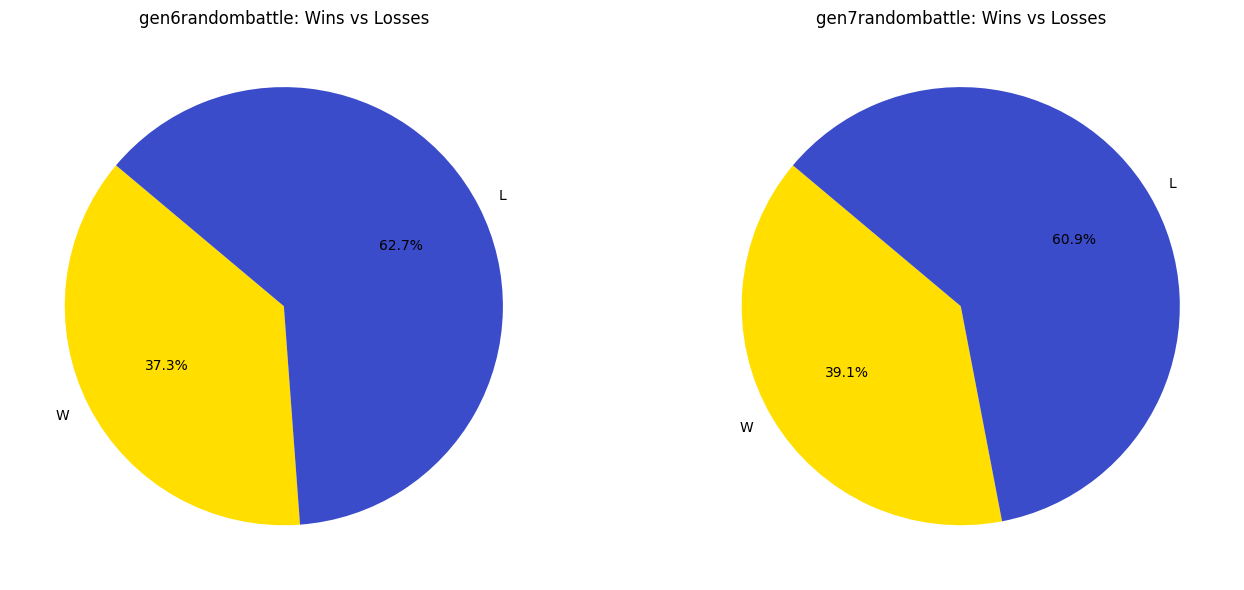

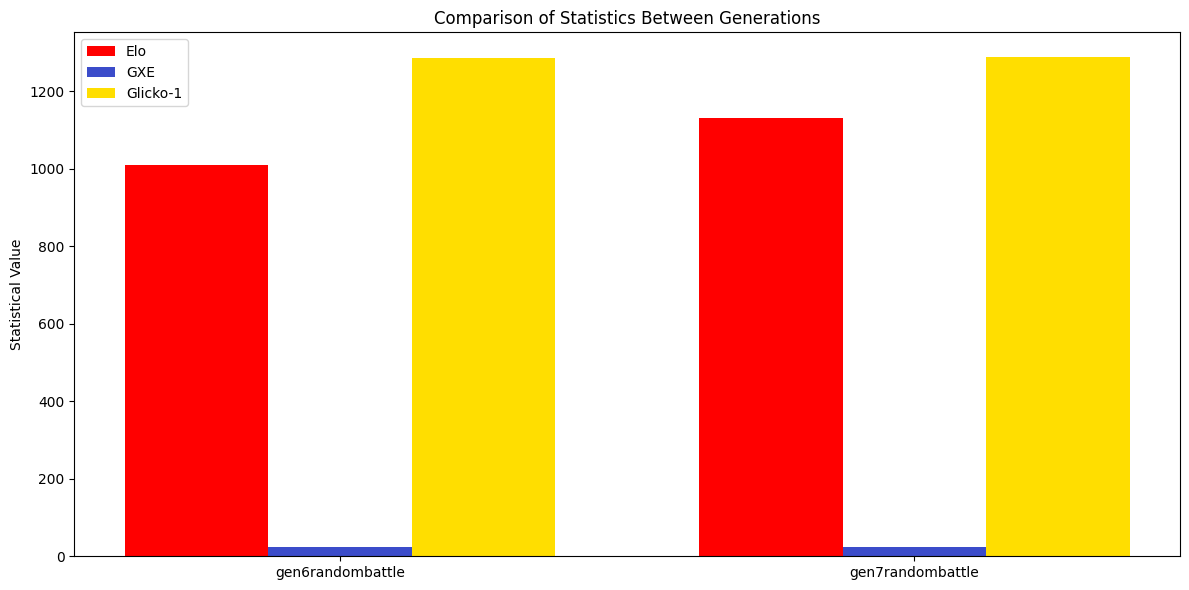

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the image
data = {
    'Generation': ['gen6randombattle', 'gen7randombattle'],
    'Elo': [1011, 1132],
    'GXE': [24.3, 24.5],
    'Glicko-1': [1286, 1288],
    'W': [22, 72],
    'L': [37, 112]
}

# Pie Charts for Wins and Losses
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Colors for Pie Charts
colors_gen6 = ['#FFDE00', '#3B4CCA']
colors_gen7 = ['#FFDE00', '#3B4CCA']

# Generation 6
axs[0].pie(
    [data['W'][0], data['L'][0]],
    labels=['W', 'L'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_gen6
)
axs[0].set_title('gen6randombattle: Wins vs Losses')

# Generation 7
axs[1].pie(
    [data['W'][1], data['L'][1]],
    labels=['W', 'L'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_gen7
)
axs[1].set_title('gen7randombattle: Wins vs Losses')

plt.tight_layout()
plt.show()

# Bar Chart for Elo, GXE, and Glicko-1
x = np.arange(len(data['Generation']))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

# Colors for Bar Chart
colors_elo = '#FF0000'
colors_gxe = '#3B4CCA'
colors_glicko = '#FFDE00'

# Plot bars with specific colors
rects1 = ax.bar(x - width, data['Elo'], width, label='Elo', color=colors_elo)
rects2 = ax.bar(x, data['GXE'], width, label='GXE', color=colors_gxe)
rects3 = ax.bar(x + width, data['Glicko-1'], width, label='Glicko-1', color=colors_glicko)

ax.set_ylabel('Statistical Value')
ax.set_title('Comparison of Statistics Between Generations')
ax.set_xticks(x)
ax.set_xticklabels(data['Generation'])
ax.legend()

plt.tight_layout()
plt.show()


Add the final result